# This notebook produces cluster star results

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
from chronology import setup, run_mcmc, make_plots
from isochrones import StarModel
import pandas as pd
import emcee

from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [60]:
df = pd.read_csv("../data/praesepe_no_outliers.csv")
df.head()

,Unnamed: 0,praesepe_oid,col1,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,...,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE,period
0,1,2,1,1635721458409799680,Gaia DR2 664963024499946496,958732839,2015.5,130.843872,0.039013,21.671633,...,2,10.34,1,1,All,2M,Simbad,130.844045,21.671699,11.17
1,8,9,8,1635721458409799680,Gaia DR2 665004702861616256,808383652,2015.5,131.366265,0.056806,21.653530,...,K,10.34,1,1,All,2M,Simbad,131.366439,21.653576,4.92
2,11,12,11,1635721458409799680,Gaia DR2 665129291274350976,1023339599,2015.5,130.150810,0.044626,21.561657,...,D,11.45,2,2,All,2M,Simbad,130.150986,21.561719,9.02
3,16,17,16,1635721458409799680,Gaia DR2 664337230586013312,672933698,2015.5,129.601086,0.055733,20.106007,...,K,10.41,0,1,All,2M,Simbad,129.601250,20.106063,4.26
4,18,19,18,1635721458409799680,Gaia DR2 664455118847781760,1237355236,2015.5,130.093225,0.029071,20.640806,...,D,14.17,2,2,All,2M,Simbad,130.093397,20.640869,14.73


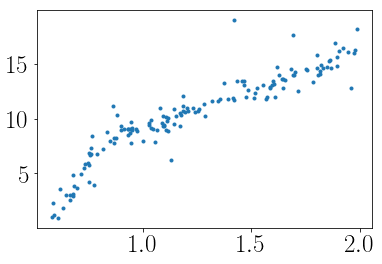

In [61]:
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.Prot1, ".")

In [62]:
# for i in df.keys():
#     print(i)

The setup

In [76]:
obs0 = pd.DataFrame(dict({"G": df.phot_g_mean_mag, "G_err": df.phot_g_mean_mag*.01,
                          "bp": df.phot_bp_mean_mag, "bp_err": df.phot_bp_mean_mag*.01,
                          "rp": df.phot_rp_mean_mag, "rp_err": df.phot_rp_mean_mag*.01,
                          "Kepler": df.Kpmag, "Kepler_err": df.Kpmag*.01,
                          "parallax": df.parallax, "parallax_err": df.parallax_error, 
                          "prot": df.Prot1, "prot_err": df.Prot1*.1,
                          "BV": df.phot_bp_mean_mag - df.phot_rp_mean_mag,
                          "BV_err": (df.phot_bp_mean_mag - df.phot_rp_mean_mag)*.1}))
obs = obs0.iloc[0]

In [77]:
# Set up the StarModel object needed to calculate the likelihood.
param_dict = {"G": (obs.G, obs.G_err),
              "bp": (obs.bp, obs.bp_err),
              "rp": (obs.rp, obs.rp_err),
              "Kepler": (obs.Kepler, obs.Kepler_err),
              "parallax": (obs.parallax, obs.parallax_err)  # Isochrones.py takes milliarcseconds
              }

mod = StarModel(mist, **param_dict)  # Set up the StarModel isochrones object.
args = [mod, obs.prot, obs.prot_err, obs.bp - obs.rp, False, False]  # the lnprob arguments

Run MCMC

In [ ]:
savedir = "cluster_results/iso_and_gyro"
gyro_only, iso_only = False, False

N = len(df)
for i in range(0, N):
    print(i, "of", N)
    
    # Set the initial values
    mass_init = 1.
    age_init = 9.
    feh_init = 0.
    eep_init = mist.eep_from_mass(mass_init, age_init, feh_init)
    distance_init = .5
    Av_init = .01
    
    # sample in linear eep, log10(age), linear feh, ln(distance) and linear Av.
    p_init = np.array([eep_init, age_init, feh_init, np.log(distance_init), Av_init])
    
    np.random.seed(42)
    
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    backend = emcee.backends.HDFBackend(filename)
    nwalkers, ndim = 24, 5
    backend.reset(nwalkers, ndim)
    
    # Set up the StarModel object needed to calculate the likelihood.
    obs = obs0.iloc[i]
    param_dict = {"G": (obs.G, obs.G_err),
                  "bp": (obs.bp, obs.bp_err),
                  "rp": (obs.rp, obs.rp_err),
                  "Kepler": (obs.Kepler, obs.Kepler_err),
                  "parallax": (obs.parallax, obs.parallax_err)}  # Isochrones.py takes milliarcseconds

    mod = StarModel(mist, **param_dict)  # Set up the StarModel isochrones object.
    args = [mod, obs.prot, obs.prot_err, obs.bp - obs.rp, gyro_only, iso_only]  # the lnprob arguments
    
    # Run the MCMC
    sampler = run_mcmc(obs.iloc[i], args, p_init, backend, burnin=15000, production=30000,
                       ndim=ndim, nwalkers=nwalkers)
        
    # Make the plots
    samples = sampler.flatchain
    mass_samps = mist.mass(samples[:, 0], samples[:, 1], samples[:, 2])
    plt.hist(mass_samps, 50);
    plt.axvline(df.mass.values[i], color="tab:orange")
    plt.savefig("{0}/{1}_marginal_mass".format(savedir, str(i).zfill(4)))
    plt.close()
    
    true_eep = mist.eep_from_mass(df.mass.values[i], df.age.values[i], df.feh.values[i])
    truths = [true_eep, df.age.values[i], df.feh.values[i],
              np.log(df.d_kpc.values[i]), df.Av.values[i]]
    print("truths = ", truths)

    make_plots(sampler, i, truths, savedir)
    
    # Save the samples
    samples = sampler.flatchain
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, str(i).zfill(4)), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples

0 of 149


  0%|          | 72/100000 [00:01<57:04, 29.18it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
  7%|▋         | 7463/100000 [02:03<27:32, 56.00it/s]  